# Part a

In [193]:
import pandas as pd
import numpy as np
import os

unigram = pd.read_csv("hw4_unigram.txt", names=["unigram"])
vocab = pd.read_csv("hw4_vocab.txt", names=["vocab"], sep="  ").join(unigram)
bigram = pd.read_csv("hw4_bigram.txt", names=["w1", "w2", "count_w1_w2"], sep="\t")

/home/rose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [194]:
# As seen in lectures slides the mle  = count(X=x)/ T where x is the vocab word and T is the total count
vocab["prob"] = vocab["unigram"] / sum(vocab.unigram.values)
print(vocab[["vocab", "prob"]][vocab.vocab.str.startswith("A")].reset_index(drop=True))

# Bigram 
def group_by_normal(x): 
    x["P(w2|w1)"] = x.count_w1_w2 / x.count_w1_w2.sum()
    return x
bigram = bigram.groupby("w1").apply(group_by_normal)

             vocab      prob
0                A  0.018407
1              AND  0.017863
2               AT  0.004313
3               AS  0.003992
4               AN  0.002999
5              ARE  0.002990
6            ABOUT  0.001926
7            AFTER  0.001347
8             ALSO  0.001310
9              ALL  0.001182
10              A.  0.001026
11             ANY  0.000632
12        AMERICAN  0.000612
13         AGAINST  0.000596
14         ANOTHER  0.000428
15           AMONG  0.000374
16             AGO  0.000357
17       ACCORDING  0.000348
18             AIR  0.000311
19  ADMINISTRATION  0.000292
20          AGENCY  0.000280
21          AROUND  0.000277
22       AGREEMENT  0.000263
23         AVERAGE  0.000259
24           ASKED  0.000258
25         ALREADY  0.000249
26            AREA  0.000231
27        ANALYSTS  0.000226
28       ANNOUNCED  0.000227
29           ADDED  0.000221
30        ALTHOUGH  0.000214
31          AGREED  0.000212
32           APRIL  0.000207
33            

# Part b

In [166]:
the_idx = vocab[vocab.vocab == "THE"].index[0]
# bigram["P(w2|w1)"] = bigram.count_w1_w2 / bigram.count_w1_w2.sum()
bigram_info = bigram[bigram.w1 == the_idx + 1].sort_values("P(w2|w1)", ascending=False).head(5) # index starts at 1 not 0
print(bigram_info)
w2 = bigram_info.w2.values
print("Most likely words to follow THE")
print(vocab.loc[w2, :])

      w1  w2  count_w1_w2  P(w2|w1)
993    4   1      2371132  0.615020
1058   4  70        51556  0.013372
1064   4  79        45186  0.011720
1060   4  73        44949  0.011659
1050   4  61        36439  0.009451
Most likely words to follow THE
     vocab  unigram      prob
1      <s>  3021866  0.036958
70    BEEN   135582  0.001658
79   AFTER   110102  0.001347
73  THIRTY   120116  0.001469
61     HAD   154509  0.001890


# Part C

In [195]:
# L u = log P u (last) P u (week) P u (the) . . . P u (one) P u (hundred) P u (points)i
words = "Last week the stock market fell by one hundred points".upper().split(" ")
prob = np.prod(vocab[vocab.vocab.isin(words)].prob.values)
L = np.log(prob)
print(L)

-64.50944034364878


In [196]:
words = "Last week the stock market fell by one hundred points".upper().split(" ")
res = vocab[vocab.vocab == words[0]].prob.values[0]
for i in range(1, len(words)):
    curr = vocab[vocab.vocab == words[i]].index[0]  + 1  # Index starts at 1 
    last = vocab[vocab.vocab == words[i-1]].index[0] + 1
    vals = bigram[(bigram.w1 == last) & (bigram.w2 == curr)]["P(w2|w1)"].values
    if len(vals > 0): 
        res  *= vals[0]
    else: 
        res *= 0 
L = np.log(res)
print(L)

-45.63283546892502


# Part D

In [197]:
# L u = log P u (last) P u (week) P u (the) . . . P u (one) P u (hundred) P u (points)i
words = "The nineteen officials sold fire insurance".upper().split(" ")
prob = np.prod(vocab[vocab.vocab.isin(words)].prob.values)
L = np.log(prob)
print(L)

-41.64345971649364


In [215]:
words = "<unk> The nineteen officials sold fire insurance .PERIOD".upper().split(" ")
res = 1
for i in range(1, len(words)):
    curr = vocab[vocab.vocab == words[i]].index[0]  + 1  # Index starts at 1 
    last = vocab[vocab.vocab == words[i-1]].index[0] + 1
    vals = bigram[(bigram.w1 == last) & (bigram.w2 == curr)]["P(w2|w1)"].values
    if len(vals > 0): 
        res  *= vals[0]
    else: 
        print("Pair Not found: ", words[i - 1], words[i])
        res *= 0 
L = np.log(res)
print(L)


Pair Not found:  NINETEEN OFFICIALS
Pair Not found:  SOLD FIRE
-inf


/home/rose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


# Part e 

In [219]:
lam = .5
def mix_model(lam):
    words = "<unk> The nineteen officials sold fire insurance .PERIOD".upper().split(" ")
    res = 1 
    for i in range(1, len(words)):
        curr = vocab[vocab.vocab == words[i]].index[0]  + 1
        last = vocab[vocab.vocab == words[i-1]].index[0] + 1
        vals = bigram[(bigram.w1 == last) & (bigram.w2 == curr)]["P(w2|w1)"].values
        if len(vals > 0): 
            p_w_w = vals[0]
        else: 
            p_w_w = 0
        p_w = vocab[vocab.vocab == words[i]].prob.values[0]
        res *= (p_w * (1 - lam) + p_w_w *  lam)
    L = np.log(res)
    return L 
hist = []
lam_opt = np.arange(0, 1, .001)
curr_max = -9999999
best_lam = 0
for lam in lam_opt: 
    L = mix_model(lam)
    hist +=[L]
    if L > curr_max: 
        curr_max = np.copy(L)
        best_lam = np.copy(lam)
print(f"Max: {curr_max}")
print(f"Lambda:  {best_lam}")

Max: -43.9012814590737
Lambda:  0.301


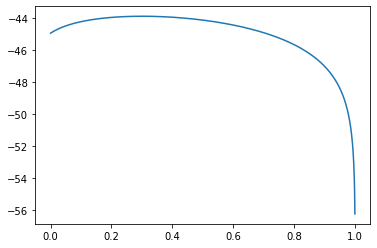

In [221]:
import matplotlib.pyplot as plt
plt.plot(lam_opt, hist)